In [67]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from preprocess import load_clean_data, data_stats, create_features, create_features_labels
from plots import plot_validation_diagram, plot_samples, plot_avg, plot_ewma
from IPython.display import display

from evaluate import evaluate_ae_models, evaluate_seq_models, evaluate_dummy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
data = load_clean_data(range(48))

Error while parsing file inxed=2
Error while parsing file inxed=4
Error while parsing file inxed=44


In [6]:
df = data_stats(data)
df.sum().sort_values(ascending=False)

N    79358
L     8075
V     7069
R     6005
/     3620
A     2543
F      802
f      260
j      229
a      150
E      106
J       83
Q       17
e       16
S        2
n        0
B        0
r        0
?        0
dtype: int64

In [2]:
df[['A', 'R', '/', 'V', 'L', 'N']]

NameError: name 'df' is not defined

In [2]:
data_range = range(37)
data_range.remove(2)
data_range.remove(4)
data = load_clean_data(data_range)
val_range = range(37,48)
val_range.remove(44)
validation = load_clean_data(val_range)

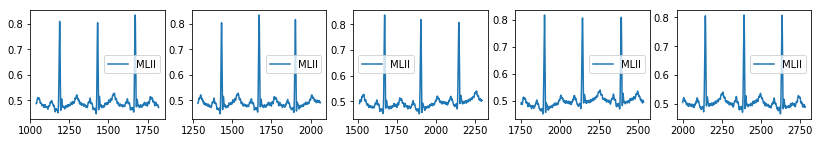

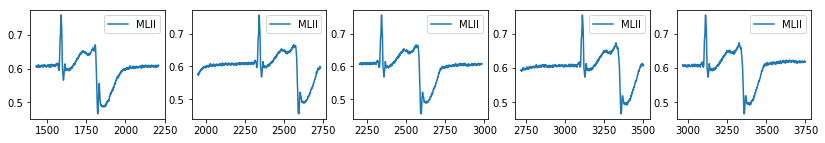

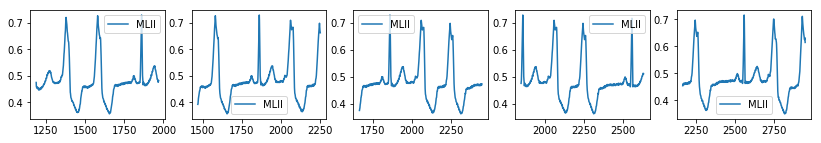

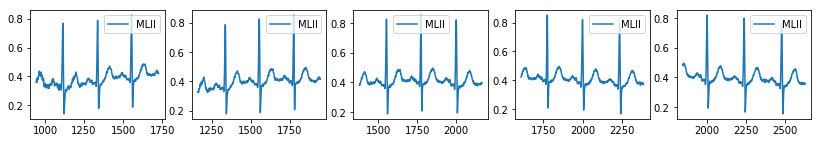

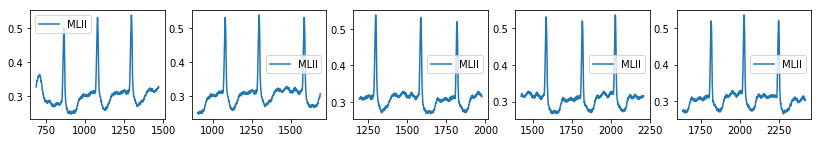

In [18]:
plot_samples(data[-10:-5])

In [22]:
#plot_avg(data[0]['signals'], 400)

In [23]:
#plot_ewma(data[0]['signals'], 400)

### Create small train/test set

In [3]:
lb = LabelBinarizer()
x_train, labels = create_features_labels(data, 784, non_beats_per_beat = 2, beat_types=['A', 'N'])
y_train = lb.fit_transform(labels)

x_test, labels = create_features_labels(validation, 784, non_beats_per_beat = 2, beat_types=['A', 'N'])
y_test = lb.transform(labels)

In [4]:
x_train.shape, x_test.shape

((166101, 784), (62343, 784))

In [5]:
x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size = .9)
x_test, _, y_test, _ = train_test_split(x_test, y_test, test_size = .9)

In [7]:
x_train.shape, x_test.shape

((16610, 784), (6234, 784))

In [8]:
ann = validation[1]['annotations']
sig = validation[1]['signals']

In [10]:
#ann[ann['Type'] == 'A'][:10]

### DummyClassifier

In [78]:
dummy = evaluate_dummy(x_train, x_test, y_train, y_test, lb.classes_, ann, sig)

### Check NN autoencoder

('Running autoencoder with config:', '[784, [], 64]')
Successfully loaded weights


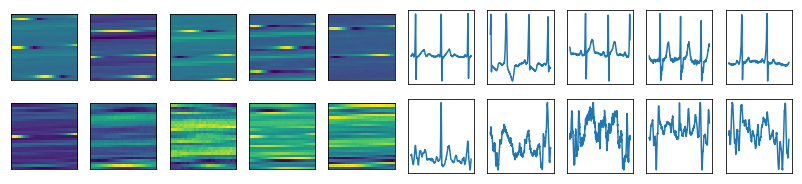

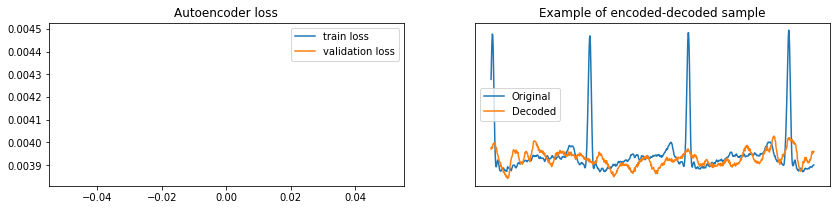

('Evaluating model with fc:', '[3]')
Successfully loaded weights
             precision    recall  f1-score   support

          A       0.00      0.00      0.00       166
          N       0.82      0.86      0.84      1856
         NB       0.94      0.95      0.94      4212

avg / total       0.88      0.90      0.89      6234



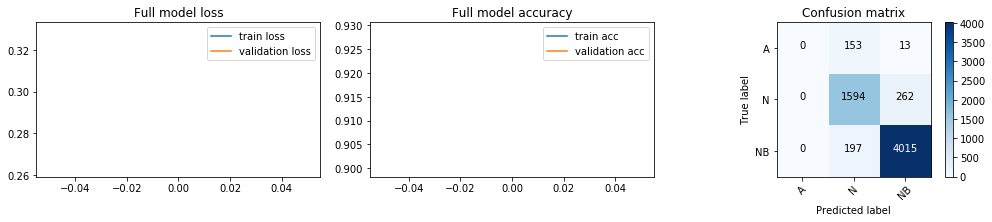

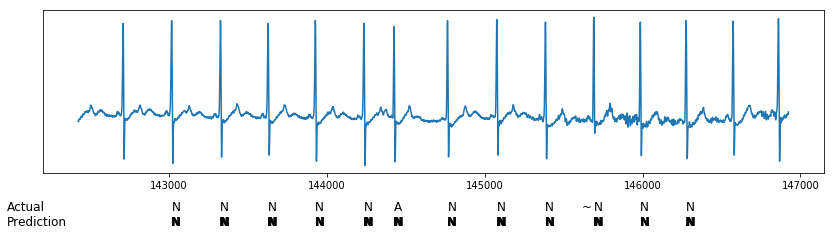

In [42]:
config = {
    'use_conv': False,
    'ae' : [ [784,[], 64] ],
    'fc' : [ [3] ]
#     'ae' : [ [784,[], 64], [784, [256, 128], 64]],
#     'fc' : [ [3], [32,3], [64,3] ]

}
nn_models = evaluate_ae_models(config, x_train, x_test, y_train, y_test, lb.classes_, ann, sig, 
                               ae_epochs=1, full_model_epochs=1, load_prev_ae=True, load_prev_full=True)

### Check CONV autoencoder

((28, 28), [16, 8, 8, 8], (2, 2))
('Running autoencoder with config:', '[(28, 28), [16, 8, 8, 8], (2, 2)]')


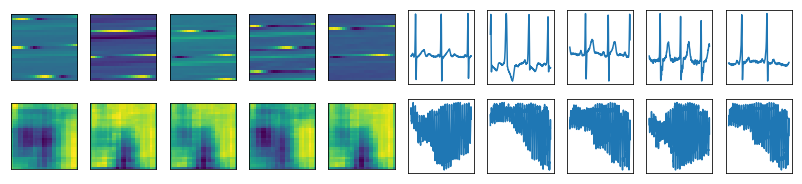

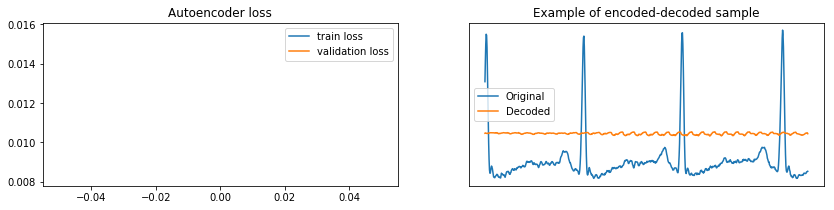

('Evaluating model with fc:', '[3]')
             precision    recall  f1-score   support

          A       0.03      1.00      0.05       166
          N       0.00      0.00      0.00      1856
         NB       0.00      0.00      0.00      4212

avg / total       0.00      0.03      0.00      6234



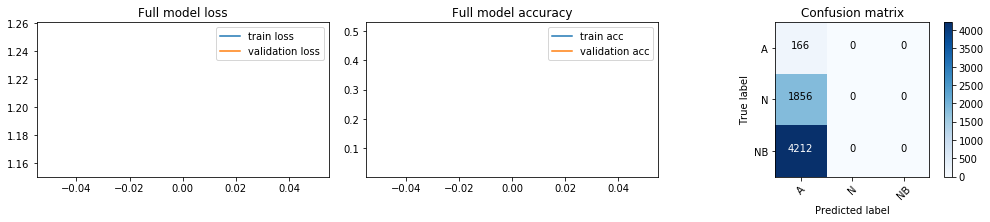

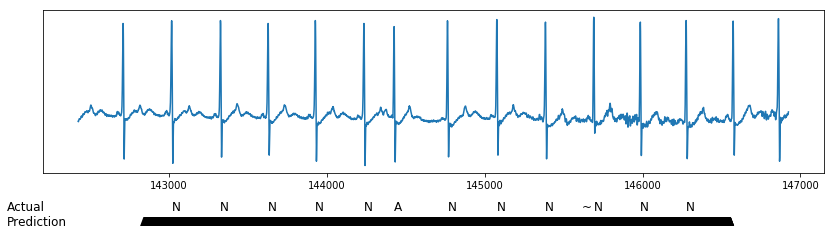

In [53]:
config = {
    'use_conv' : True,
    'ae' : [[(28, 28), [16, 8 , 8, 8], (2,2)]],
    'fc' : [ [3], [64,3], [128,3], [1024,3] ]
}
conv_models = evaluate_nn_models(config,  x_train, x_test, y_train, y_test, lb.classes_, ann, sig, 
                                    ae_epochs=1, full_model_epochs=1, load_prev_ae=False, load_prev_full=False)

### Sequential models

('Running sequential model:', "{'units': [1024], 'dropout': 0.5, 'filters': [16, 32, 64]}")
Successfully loaded weights
Train on 16610 samples, validate on 6234 samples
Epoch 1/1
16610/16610 [==============================] - 29s - loss: 0.2582 - acc: 0.9435 - val_loss: 2.3919 - val_acc: 0.0266
             precision    recall  f1-score   support

          A       0.03      1.00      0.05       166
          N       0.00      0.00      0.00      1856
         NB       0.00      0.00      0.00      4212

avg / total       0.00      0.03      0.00      6234



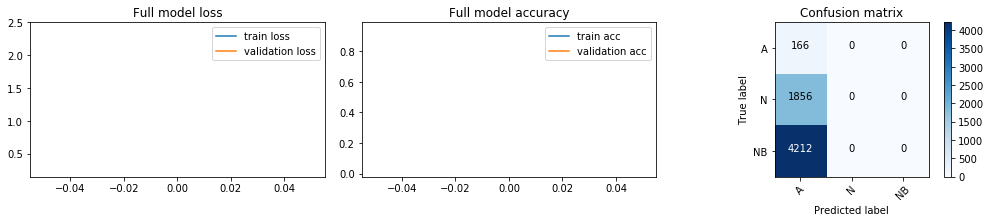

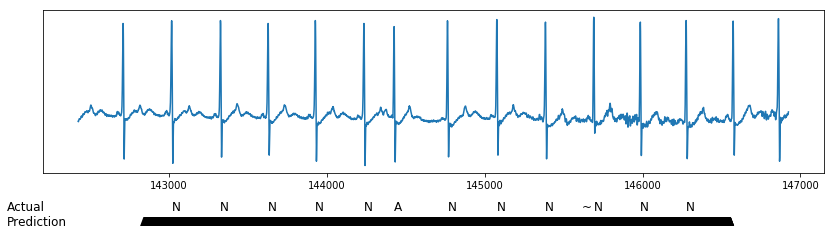

In [28]:
config = [
    {'filters' : [16, 32, 64], 'units': [1024], 'dropout': 0.5},
#     {'filters' : [16, 32, 64], 'units': [2048], 'dropout': 0.5},
#     {'filters' : [16, 32, 64, 128], 'units': [1024], 'dropout': 0.5}
]
seq_models = evaluate_seq_models(config, x_train, x_test, y_train, y_test, lb.classes_, ann, sig, epochs = 1, load_prev=True)

In [17]:
def print_raport(result):
    df  = pd.DataFrame(result)
    display(df[['ae', 'fc', 'val_acc', 'precision', 'recall', 'f1_score']].round(2))

In [60]:
def print_seq_raport(result):
    df  = pd.DataFrame(result)    
    display(df[['filters', 'units', 'dropout', 'val_acc', 'precision', 'recall', 'f1_score']].round(2))

In [87]:
def print_dummy_raport(dummy):
    display(pd.DataFrame(dummy, index = [0], columns=['val_acc', 'precision', 'recall', 'f1_score']).round(2))

In [88]:
print_dummy_raport(dummy), print_raport(nn_models); print_raport(conv_models); print_seq_raport(seq_models)

,val_acc,precision,recall,f1_score
0,0.39,0.33,0.33,0.29


,ae,fc,val_acc,precision,recall,f1_score
0,"[784, [], 64]",[3],0.9,0.59,0.6,0.59


,ae,fc,val_acc,precision,recall,f1_score
0,"[(28, 28), [16, 8, 8, 8], (2, 2)]",[3],0.03,0.01,0.33,0.02


,filters,units,dropout,val_acc,precision,recall,f1_score
0,"[16, 32, 64]",[1024],0.5,0.03,0.01,0.33,0.02


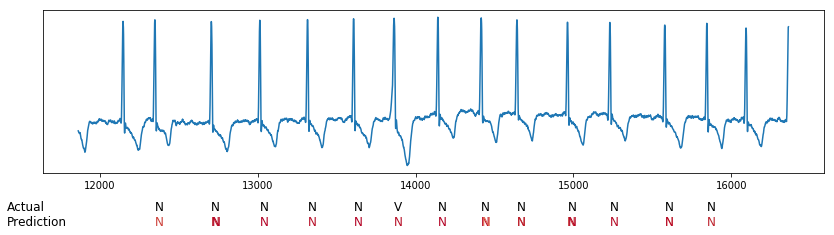

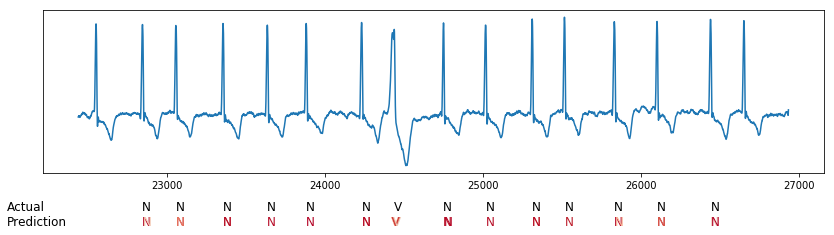

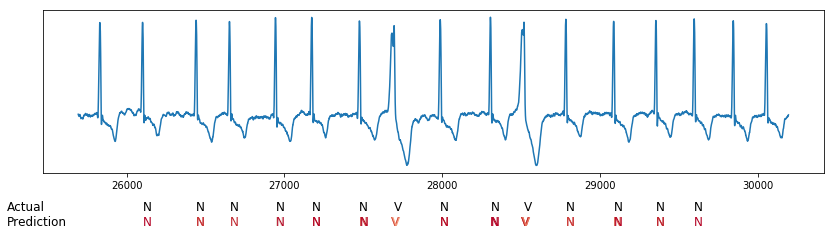

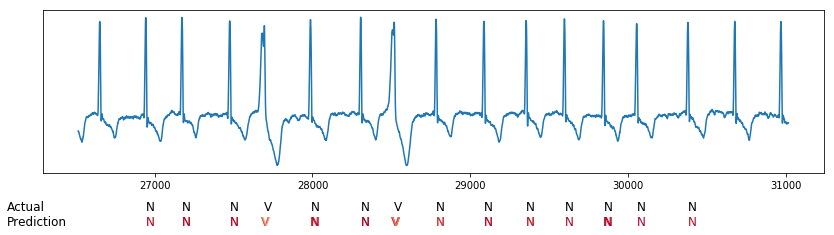

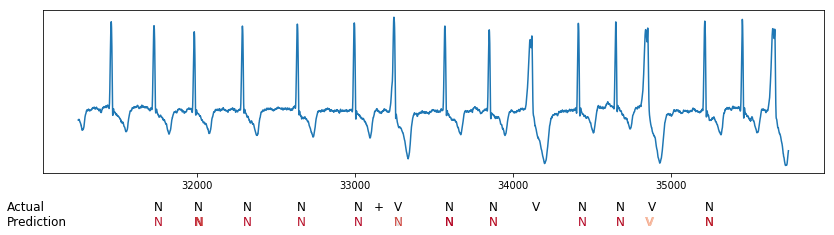

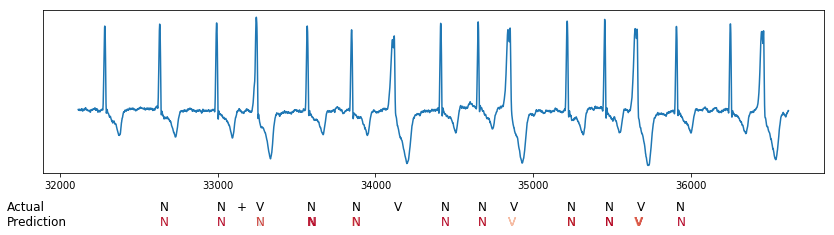

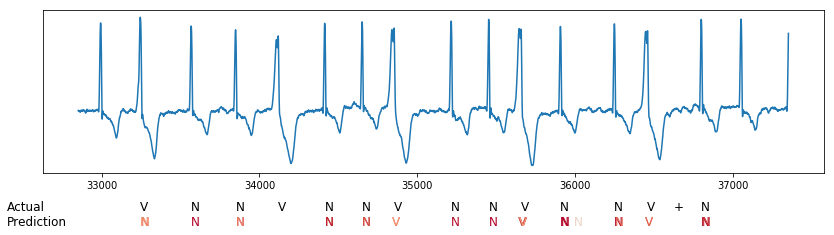

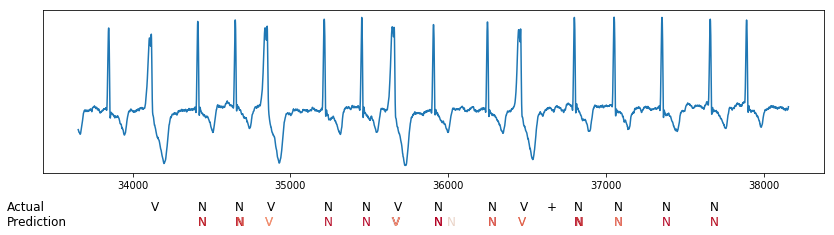

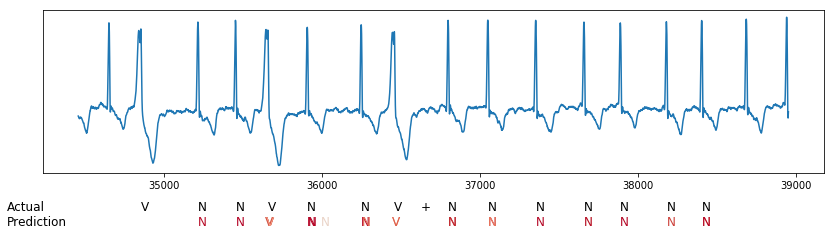

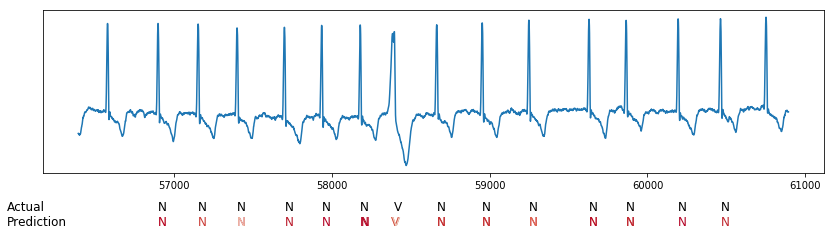

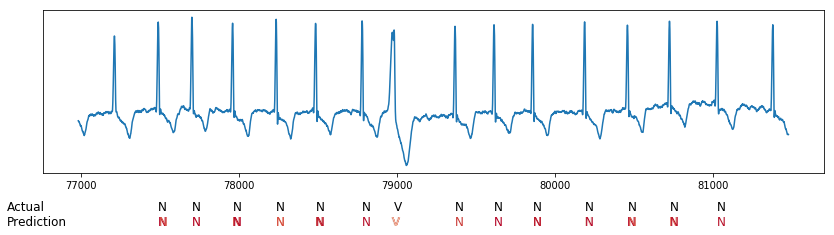

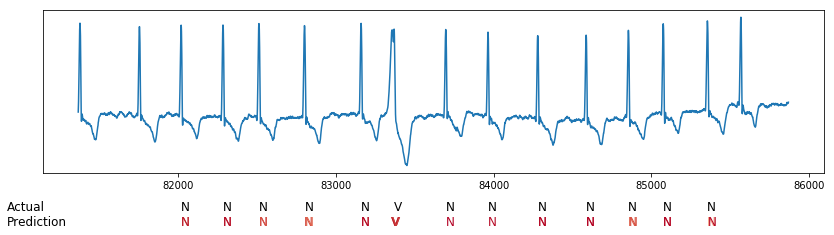

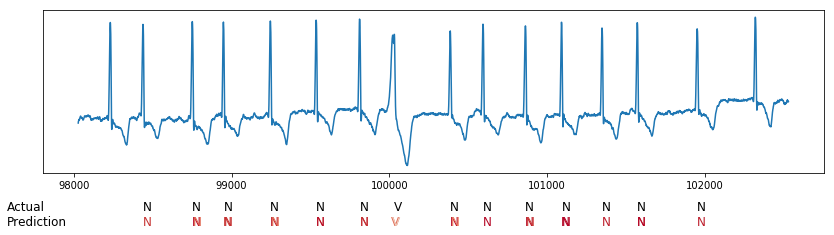

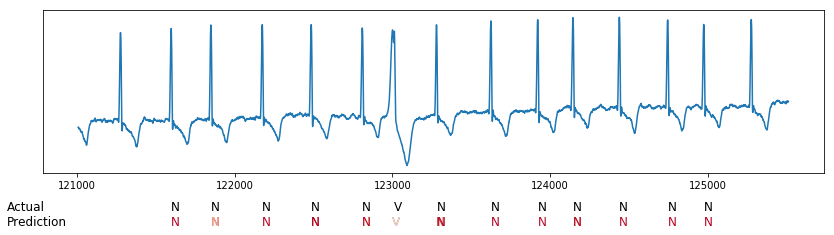

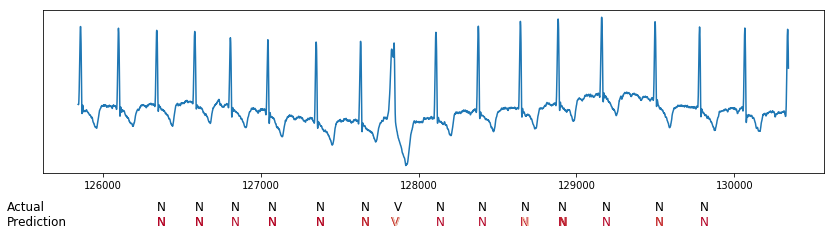

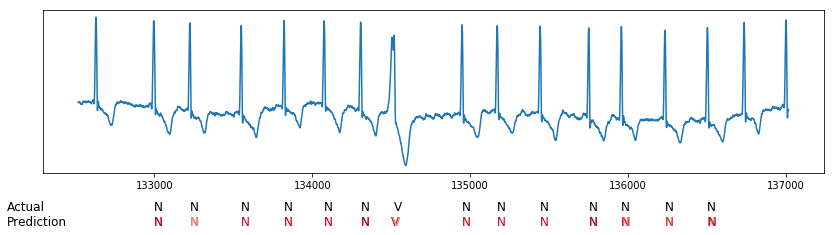

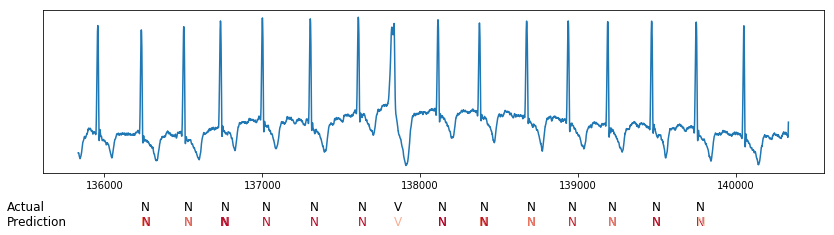

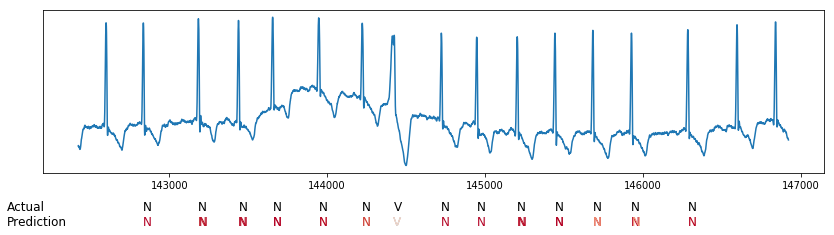

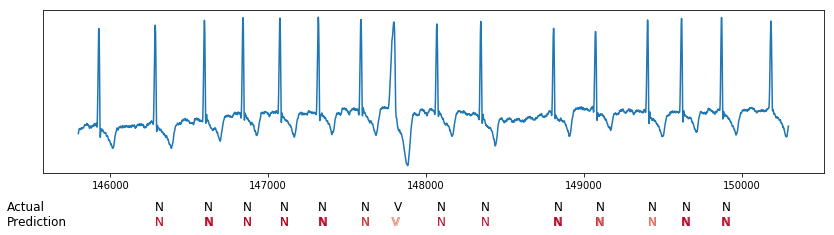

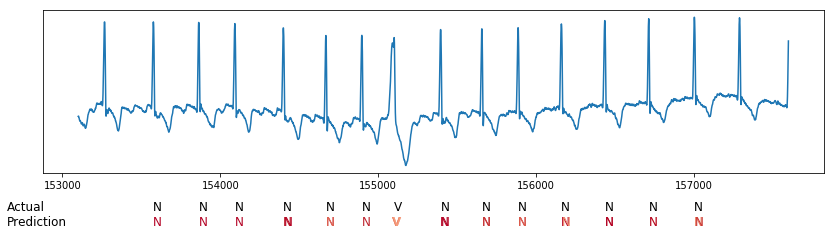

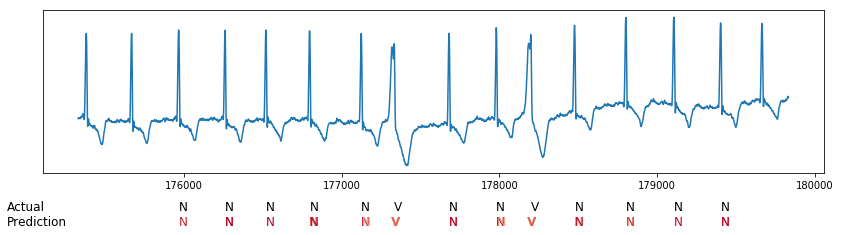

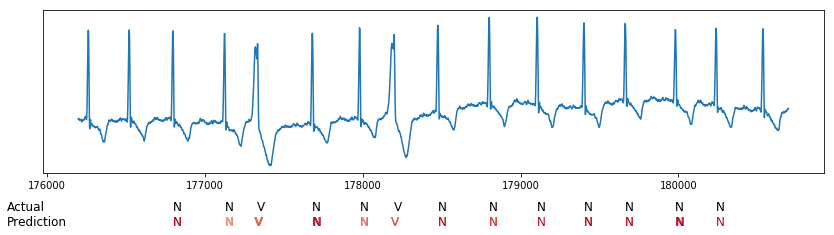

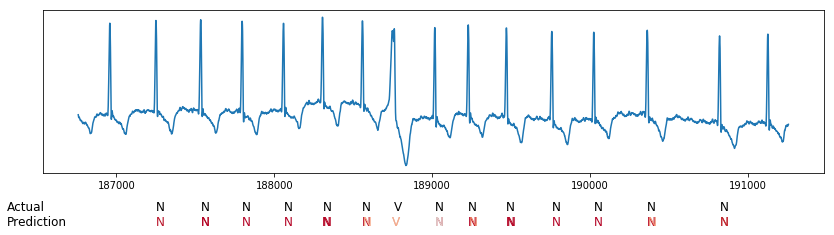

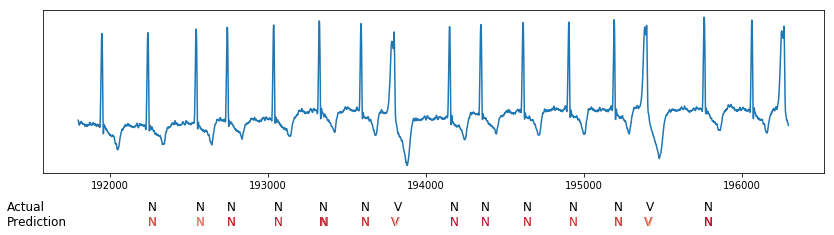

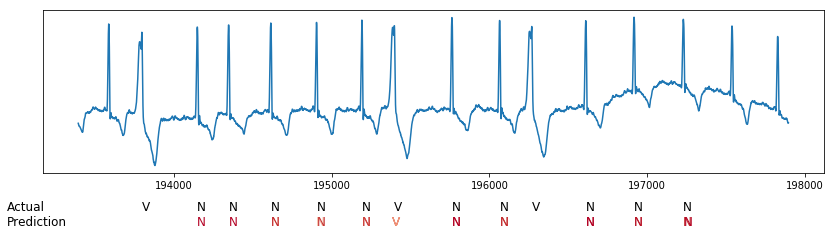

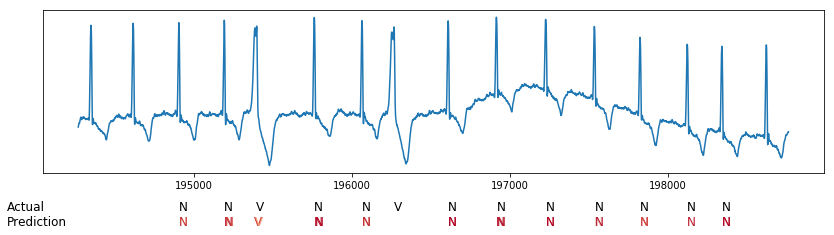

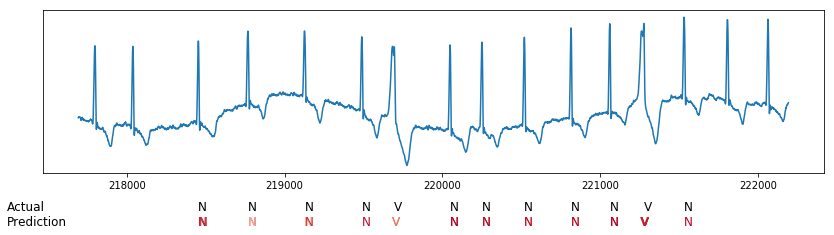

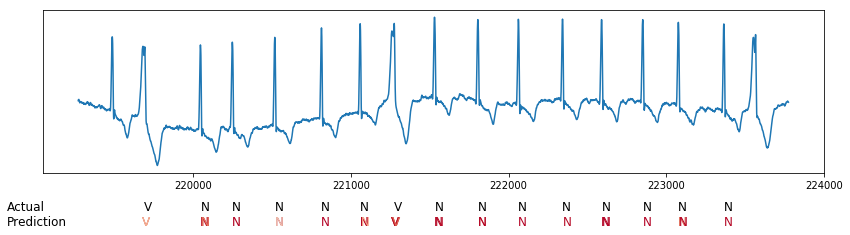

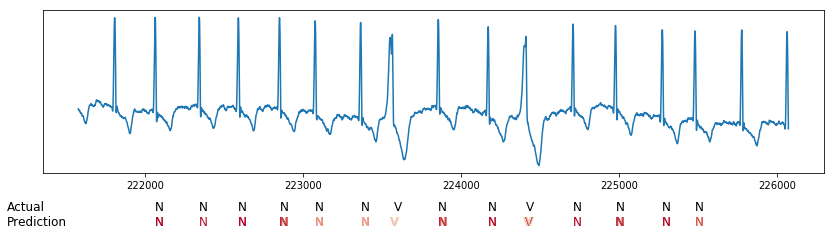

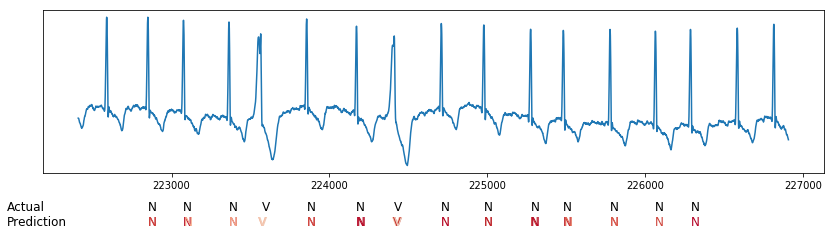

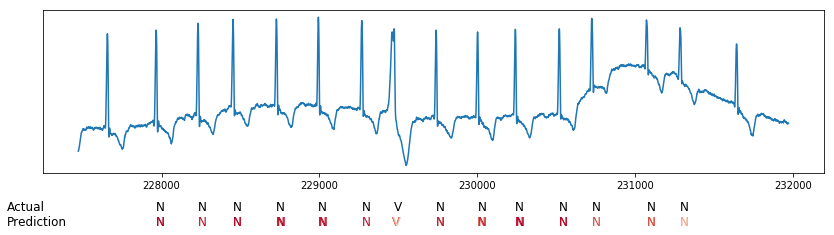

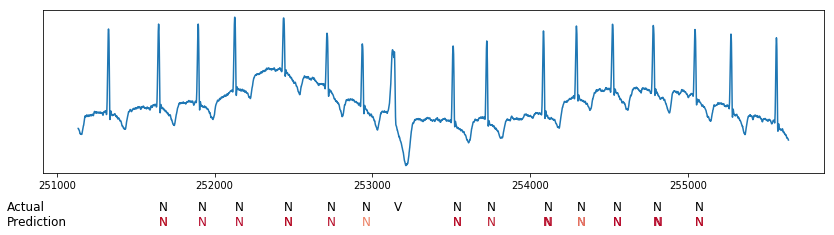

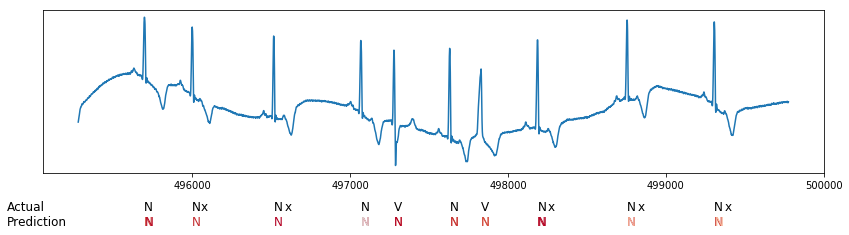

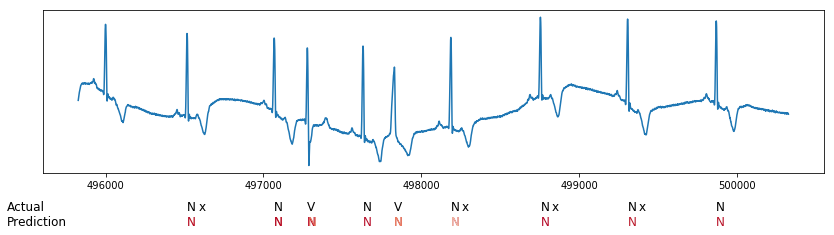

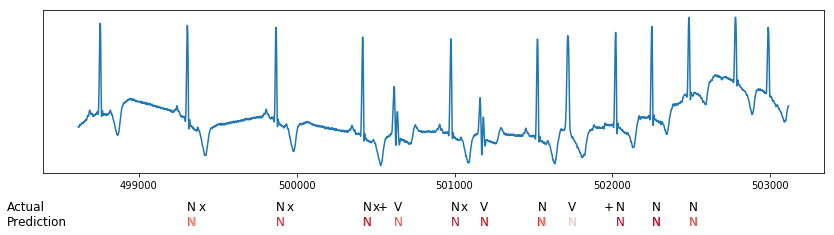

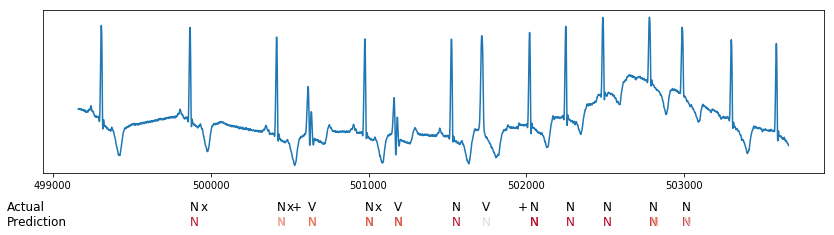

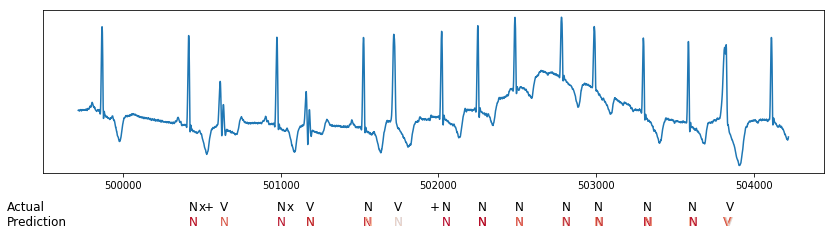

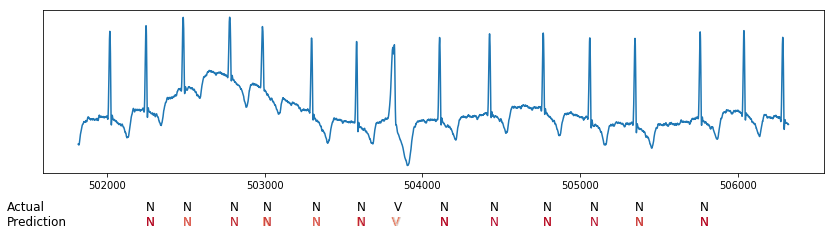

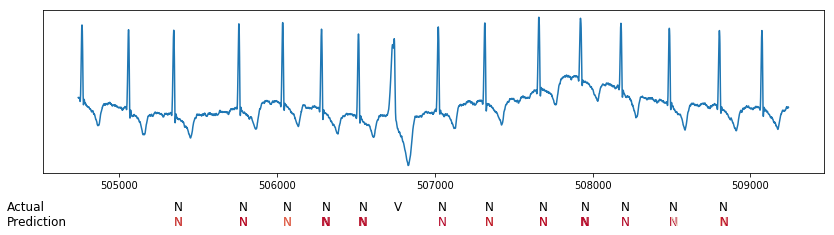

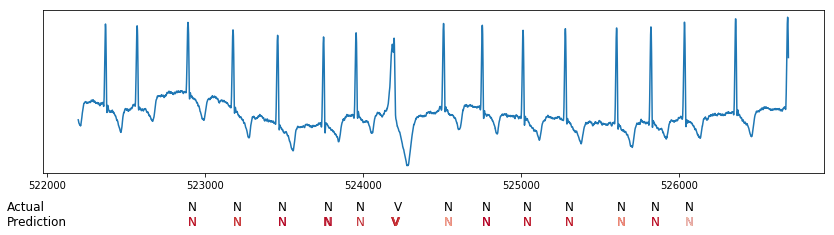

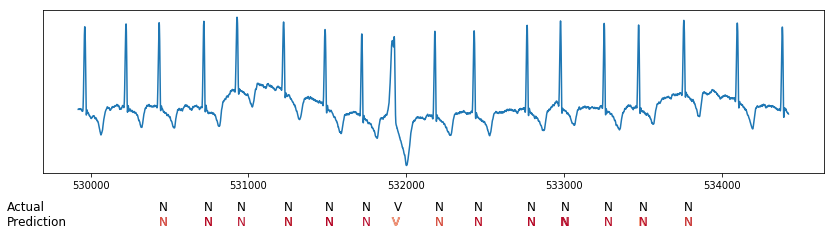

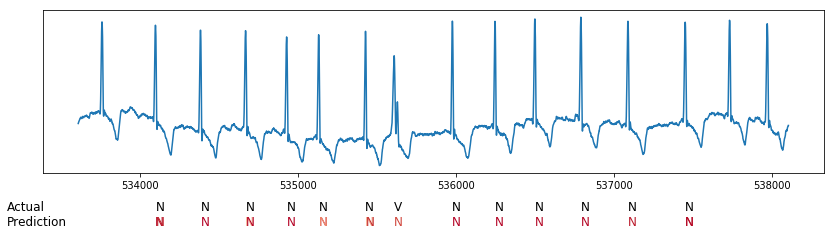

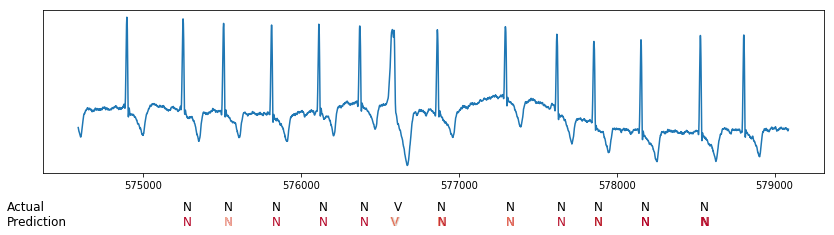

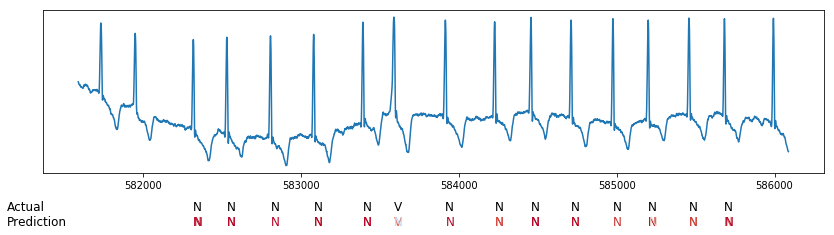

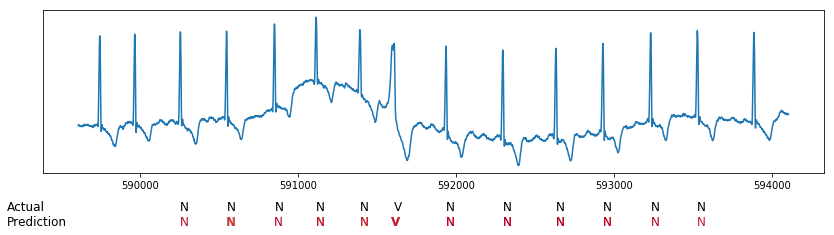

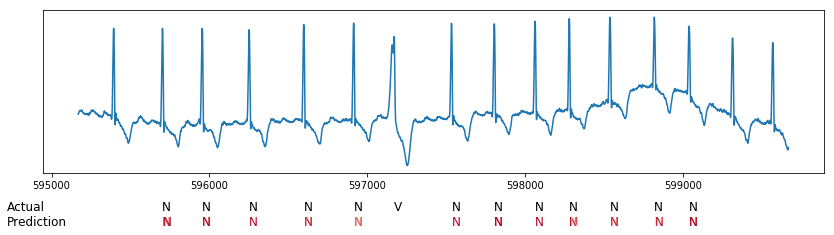

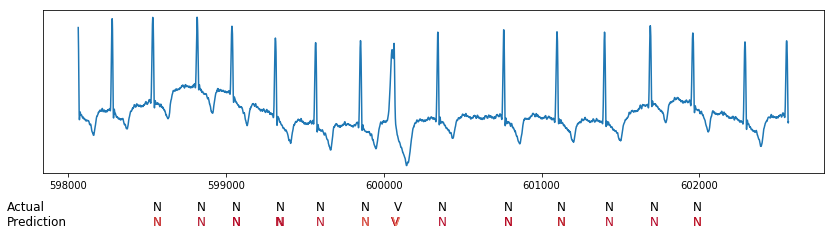

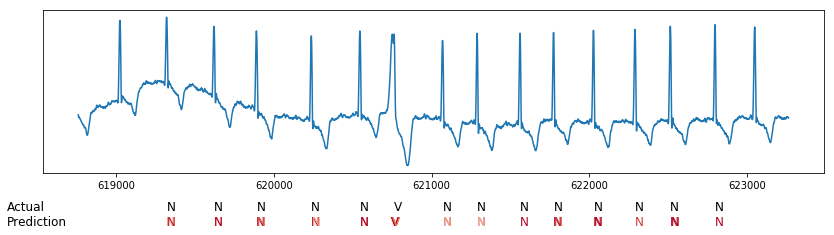

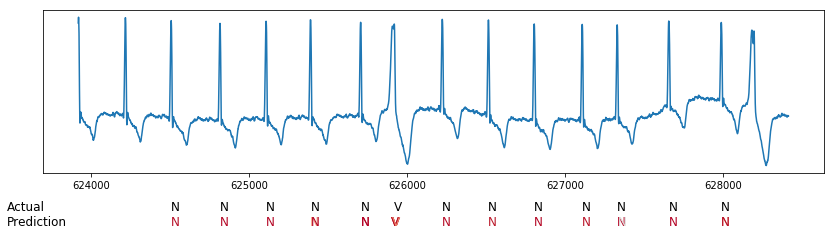

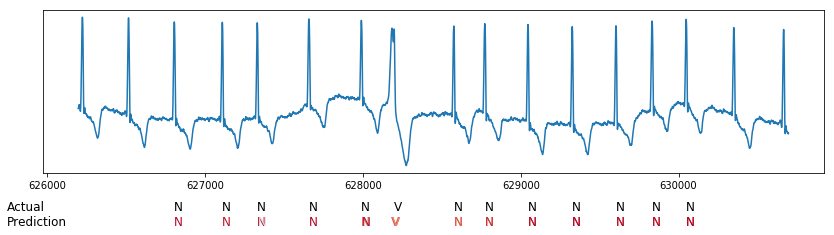

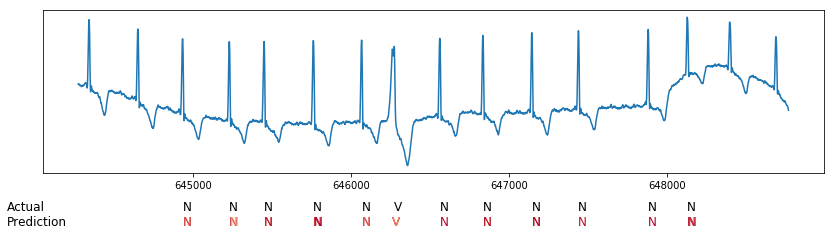

ValueError: cannot reshape array of size 1858 into shape (28,28,1)

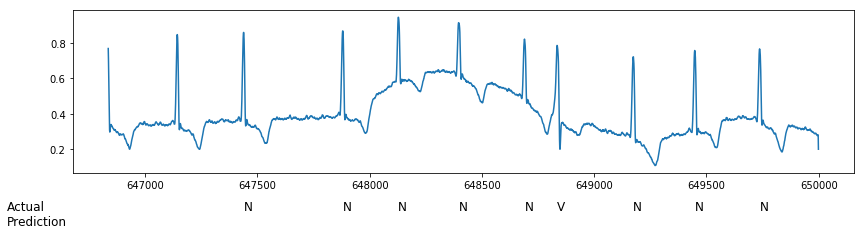

In [22]:
for s in ann['Sample'][ann['Type'] == 'V']:
    plot_validation_diagram(models[0]['model'], lb.classes_, ann, sig,  s - 2000, s + 2500, mark_pred_val=True)      